In [1]:
!pip install pyspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e8842d3e069fdea8a0323cb4e7efcc08c15cb039d411a0ee11e190c61b921e05
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import findspark
findspark.init()
from pyspark.sql import SQLContext, SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window

spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("Combine CASTNET Files")
         .config("spark.ui.port", "4050")
         .getOrCreate())

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [3]:
import os
import shutil
import sys
import time
import numpy as np
import pandas as pd
from google.colab import drive

drive_root = "/drive"
drive.mount(drive_root)

file_directory = os.path.join(drive_root, "My Drive", "AML Group 24")
os.listdir(file_directory)

FILE_OUTPUT = "output"
if not os.path.exists(FILE_OUTPUT):
    os.makedirs(FILE_OUTPUT)

Mounted at /drive


In [4]:
met_gas_loc = os.path.join(file_directory, "met_gas_site_cleaned.snappy.parquet")
result = pd.read_parquet(met_gas_loc)
display(result)

,SITE_ID,DATE_TIME,TEMPERATURE,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,...,QA_CODE,NO,NOY,NOYDIF,SO2_GA,LATITUDE,LONGITUDE,ELEVATION,LAND_USE,TERRAIN
0,BEL116,2013-01-01 22:00:00,3.859,67.79,0.475,23.32,0.0,1.008,318.500,36.97,...,3,0.029,2.733439,2.422802,0.999000,39.028177,-76.817127,47.0,Range,Flat
1,BEL116,2013-01-02 03:00:00,1.573,63.01,0.471,30.53,0.0,0.725,5.038,38.44,...,3,0.025,2.733439,2.422802,2.382000,39.028177,-76.817127,47.0,Range,Flat
2,BEL116,2013-01-02 07:00:00,-0.347,64.32,9.450,28.37,0.0,0.674,352.500,34.32,...,3,0.031,2.733439,2.422802,2.926000,39.028177,-76.817127,47.0,Range,Flat
3,BEL116,2013-01-02 08:00:00,-0.440,64.22,106.400,26.00,0.0,0.818,316.400,34.06,...,3,0.733,2.733439,2.422802,2.835000,39.028177,-76.817127,47.0,Range,Flat
4,BEL116,2013-01-02 15:00:00,1.486,44.63,182.800,33.69,0.0,1.114,344.200,51.09,...,3,0.713,2.733439,2.422802,1.317000,39.028177,-76.817127,47.0,Range,Flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572898,PND165,2022-12-20 16:00:00,-7.474,26.00,22.000,45.25,0.0,2.600,163.000,14.00,...,3,0.318,0.657000,0.339000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling
572899,PND165,2022-12-23 05:00:00,-17.320,56.00,1.000,44.08,0.0,1.400,68.000,18.00,...,3,0.014,0.393000,0.379000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling
572900,PND165,2022-12-25 00:00:00,-2.802,26.00,0.000,42.79,0.0,6.300,323.000,6.00,...,3,0.006,0.180000,0.174000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling
572901,PND165,2022-12-26 07:00:00,-2.663,81.00,2.000,39.20,0.0,1.500,58.000,25.00,...,3,0.010,0.378000,0.368000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling


# EPA

# Generate the distribution curve for Ozone Concentration

In [6]:
import os
import shutil
import sys
import time
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

drive_root = "/content/drive"
drive.mount(drive_root)

file_directory = os.path.join(drive_root, "My Drive", "AML Group 24")
os.listdir(file_directory)

met_gas_loc = os.path.join(file_directory, "met_gas_site_cleaned.snappy.parquet")
result = pd.read_parquet(met_gas_loc)
display(result)

Mounted at /content/drive


,SITE_ID,DATE_TIME,TEMPERATURE,RELATIVE_HUMIDITY,SOLAR_RADIATION,OZONE,PRECIPITATION,WINDSPEED,WIND_DIRECTION,SIGMA_THETA,...,QA_CODE,NO,NOY,NOYDIF,SO2_GA,LATITUDE,LONGITUDE,ELEVATION,LAND_USE,TERRAIN
0,BEL116,2013-01-01 22:00:00,3.859,67.79,0.475,23.32,0.0,1.008,318.500,36.97,...,3,0.029,2.733439,2.422802,0.999000,39.028177,-76.817127,47.0,Range,Flat
1,BEL116,2013-01-02 03:00:00,1.573,63.01,0.471,30.53,0.0,0.725,5.038,38.44,...,3,0.025,2.733439,2.422802,2.382000,39.028177,-76.817127,47.0,Range,Flat
2,BEL116,2013-01-02 07:00:00,-0.347,64.32,9.450,28.37,0.0,0.674,352.500,34.32,...,3,0.031,2.733439,2.422802,2.926000,39.028177,-76.817127,47.0,Range,Flat
3,BEL116,2013-01-02 08:00:00,-0.440,64.22,106.400,26.00,0.0,0.818,316.400,34.06,...,3,0.733,2.733439,2.422802,2.835000,39.028177,-76.817127,47.0,Range,Flat
4,BEL116,2013-01-02 15:00:00,1.486,44.63,182.800,33.69,0.0,1.114,344.200,51.09,...,3,0.713,2.733439,2.422802,1.317000,39.028177,-76.817127,47.0,Range,Flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572898,PND165,2022-12-20 16:00:00,-7.474,26.00,22.000,45.25,0.0,2.600,163.000,14.00,...,3,0.318,0.657000,0.339000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling
572899,PND165,2022-12-23 05:00:00,-17.320,56.00,1.000,44.08,0.0,1.400,68.000,18.00,...,3,0.014,0.393000,0.379000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling
572900,PND165,2022-12-25 00:00:00,-2.802,26.00,0.000,42.79,0.0,6.300,323.000,6.00,...,3,0.006,0.180000,0.174000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling
572901,PND165,2022-12-26 07:00:00,-2.663,81.00,2.000,39.20,0.0,1.500,58.000,25.00,...,3,0.010,0.378000,0.368000,0.404998,42.929031,-109.787796,2386.0,Forest,Rolling


<ipython-input-7-12be56ce84df>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([(y*100) for y in plt.gca().get_yticks()])


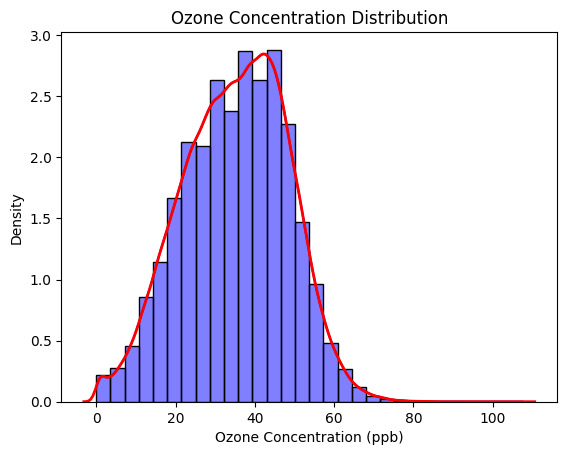

In [7]:
# Create a histogram
sns.histplot(data=result, x='OZONE', kde=True, color='blue', bins=30, stat="density")

# Create a KDE plot with a different color (e.g., red)
sns.kdeplot(data=result, x='OZONE', color='red', linewidth=2)

# Set labels and titles
plt.xlabel('Ozone Concentration (ppb)')
plt.ylabel('Density')
plt.title('Ozone Concentration Distribution')

# Set y-axis to display percentages
plt.gca().set_yticklabels([(y*100) for y in plt.gca().get_yticks()])

# Display the plot
plt.show()

In [8]:
result.columns

Index(['SITE_ID', 'DATE_TIME', 'TEMPERATURE', 'RELATIVE_HUMIDITY',
       'SOLAR_RADIATION', 'OZONE', 'PRECIPITATION', 'WINDSPEED',
       'WIND_DIRECTION', 'SIGMA_THETA', 'FLOW_RATE', 'WINDSPEED_SCALAR',
       'SHELTER_TEMPERATURE', 'QA_CODE', 'NO', 'NOY', 'NOYDIF', 'SO2_GA',
       'LATITUDE', 'LONGITUDE', 'ELEVATION', 'LAND_USE', 'TERRAIN'],
      dtype='object')

In [9]:
df_X = result.drop(columns=['OZONE','DATE_TIME','QA_CODE','SITE_ID'])
df_X['LAND_USE'] = result['LAND_USE'].astype('category').cat.codes
df_X['TERRAIN'] = result['TERRAIN'].astype('category').cat.codes
df_y = result['OZONE']

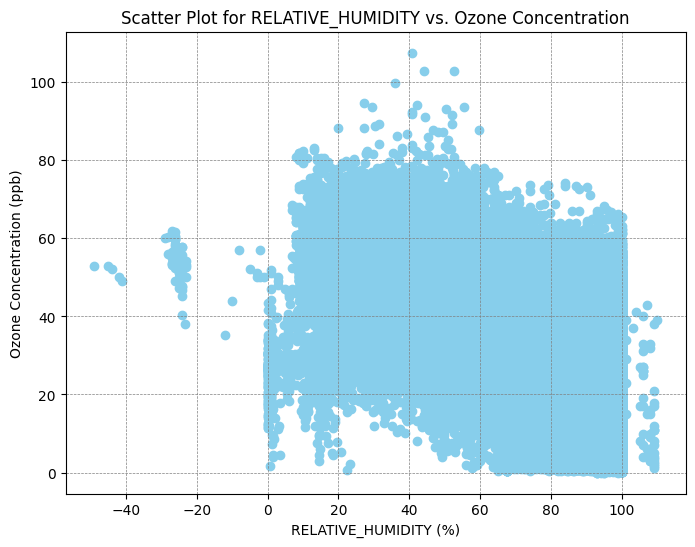

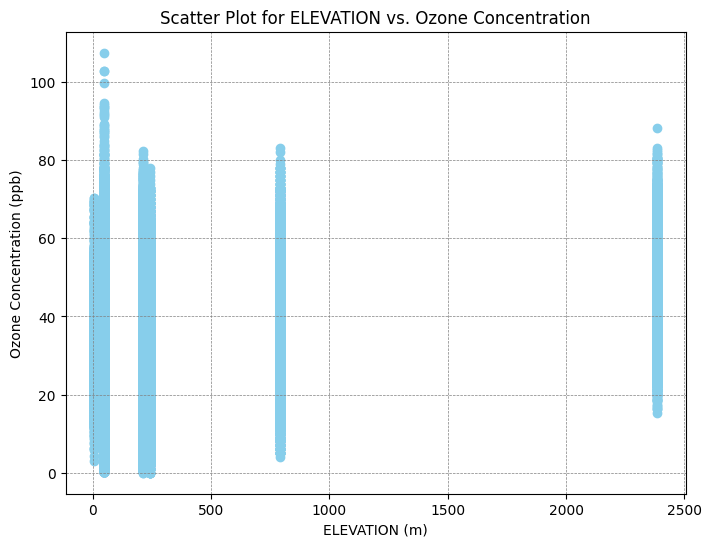

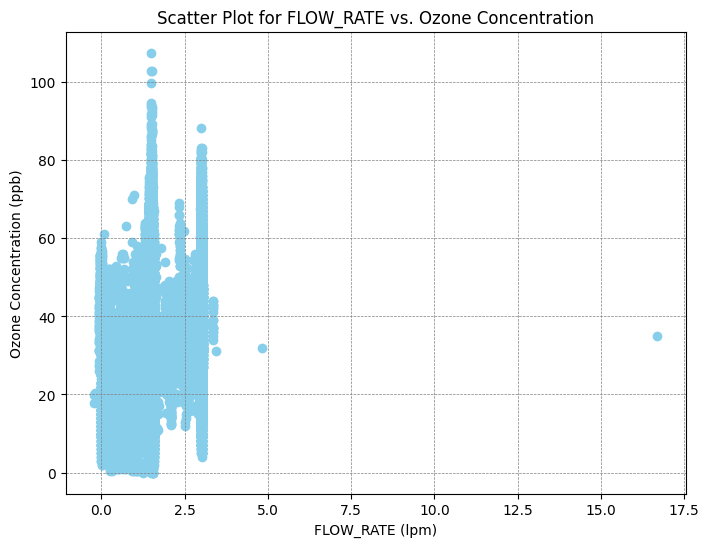

In [10]:
from sklearn.linear_model import LinearRegression

r2_values = []

# Loop through each feature in df_X
for feature_name in df_X.columns:
    # Select the feature and target variable
    X = df_X[[feature_name]]
    #print(type(df_X))
    y = df_y

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict the target variable using the model
    y_pred = model.predict(X)

    # Calculate the R-squared value
    r2 = model.score(X, y)

    # Append the R-squared value and feature name to the list
    r2_values.append((feature_name, r2))

# Sort the list by R-squared values in descending order
r2_values.sort(key=lambda x: x[1], reverse=True)

# Select the top 3 features with the highest R-squared values
top_features = r2_values[:3]

# Extract feature names and corresponding R-squared values
top_feature_names, top_r2_values = zip(*top_features)

#units
units = {"RELATIVE_HUMIDITY":"%", "ELEVATION":"m", "FLOW_RATE":"lpm"}

# Create scatter plots for the top 3 features
for feature_name in top_feature_names:
    X = df_X[[feature_name]]
    y = df_y
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, color='skyblue')
    #plt.plot(X, y_pred, color='red', label='Predicted', linewidth=2)
    plt.xlabel(f"{feature_name} ({units[feature_name]})")
    plt.ylabel('Ozone Concentration (ppb)')
    plt.title(f'Scatter Plot for {feature_name} vs. Ozone Concentration')
    plt.grid(True, linestyle='--', color='gray', linewidth=0.5)

    # Adjust the axis limits to zoom out
    # plt.xlim(min(X) - 1, max(X) + 1)  # Adjust the x-axis limits
    # plt.ylim(min(y) - 5, max(y) + 5)  # Adjust the y-axis limits

    #plt.legend()
    plt.show()

In [ ]:
r2_values

[('RELATIVE_HUMIDITY', 0.40521898567649817),
 ('ELEVATION', 0.23012376879409868),
 ('FLOW_RATE', 0.2000151480301966),
 ('LONGITUDE', 0.16063495972852282),
 ('NOYDIF', 0.15150645868985468),
 ('NOY', 0.13746496225682914),
 ('SOLAR_RADIATION', 0.1210952919014463),
 ('LATITUDE', 0.042060725433270885),
 ('WINDSPEED_SCALAR', 0.0353788683427636),
 ('LAND_USE', 0.03533231574507856),
 ('WINDSPEED', 0.028068823986490243),
 ('NO', 0.026733229982545348),
 ('TEMPERATURE', 0.020090452448711216),
 ('SHELTER_TEMPERATURE', 0.01293797225083948),
 ('TERRAIN', 0.007504934598059121),
 ('WIND_DIRECTION', 0.00744974382516661),
 ('SIGMA_THETA', 0.0005875389140399534),
 ('SO2_GA', 1.3914439095596975e-05),
 ('PRECIPITATION', 6.261166630605608e-06)]